# 125. Malware Detection - binary classification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# 'malware.csv' 파일을 읽어와 데이터프레임(df)로 저장
# index_col=0 : 첫 번째 열을 데이터프레임의 인덱스로 설정
df = pd.read_csv('malware.csv', index_col=0)

df.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
65416,VirusShare_3ede9b62781398a2e39a0f6af9356a54,3ede9b62781398a2e39a0f6af9356a54,332,224,258,10,0,117760,392192,0,...,5,3.425849,2.458492,4.035538,3146.400000,48,9640,72,15,0
23220,fxsocm.dll,9a0959a682d8eba06d0bd181c49ee2a8,332,224,8462,7,10,112640,29696,0,...,8,3.911994,2.669737,5.335373,1222.750000,164,4889,72,16,1
118017,VirusShare_abe7101746242c922a539ba461db4e38,abe7101746242c922a539ba461db4e38,332,224,258,10,0,119808,385024,0,...,6,3.776760,2.458492,5.317552,2740.166667,48,9640,72,15,0
69842,VirusShare_64a1247fc96d5bc2994ef89ca09adee8,64a1247fc96d5bc2994ef89ca09adee8,332,224,258,10,0,120320,385024,0,...,6,3.756068,2.458492,5.317552,2739.500000,48,9640,72,15,0
22165,asferror.dll,ebc23440aa9cc4f08241d35147c1d5b5,332,224,8462,7,10,0,7168,0,...,2,3.488703,3.471506,3.505901,3050.000000,888,5212,0,16,1


In [ ]:
df.shape

(10000, 57)

In [ ]:
# 'legitimate' 열의 각 값이 몇 번 등장하는지 계산하여 출력
df['legitimate'].value_counts()

,count
legitimate,
0,7071
1,2929


In [ ]:
df.columns

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

- Name : 제외
- md5 : hash value 제외

In [ ]:
# 데이터프레임에서 모든 행을 유지하고, 두 번째 열(index=1)까지 제외한 나머지 열만 선택하여 새로운 데이터프레임 생성
df = df.iloc[:, 2:]

# 데이터프레임의 차원(행 개수, 열 개수)을 출력
df.shape

(10000, 55)

In [ ]:
# 'legitimate' 열을 데이터프레임에서 제거(pop)하고, 해당 열의 값을 y에 저장
y = df.pop('legitimate').values

# 데이터프레임의 나머지 값들을 X에 저장 (입력 데이터)
X = df.values

- Train, Test split

In [ ]:
# 데이터를 학습용(train)과 테스트용(test)으로 분할
# test_size=0.2 : 전체 데이터의 20%를 테스트 세트로 사용
# random_state=0 : 실행할 때마다 동일한 방식으로 데이터를 나누도록 설정 (재현성 확보)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 학습 및 테스트 데이터의 크기 출력 (각 데이터셋의 (행 개수, 열 개수))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 54), (2000, 54), (8000,), (2000,))

In [ ]:
# StandardScaler 객체 생성 (데이터 표준화를 위한 스케일러)
sc = StandardScaler()

# 학습 데이터(X_train)에 대해 평균을 0, 표준편차를 1로 변환 (표준화 적용)
X_train = sc.fit_transform(X_train)

# 테스트 데이터(X_test)에도 동일한 변환을 적용 (학습 데이터의 기준을 사용하여 변환)
X_test  = sc.transform(X_test)

In [ ]:
# NumPy 배열(X_train)을 PyTorch 텐서로 변환 (데이터 타입: float32)
X_train_ts = torch.tensor(X_train, dtype=torch.float32)
X_test_ts = torch.tensor(X_test, dtype=torch.float32)

# NumPy 배열(y_train)을 PyTorch 텐서로 변환 (데이터 타입: float32)
# .view(-1, 1) : 1D 텐서를 2D 형태(열 벡터)로 변환하여 사용
y_train_ts = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_ts = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

## ``nn.Module``을 이용한 사용자 정의 Logistic Regression model 정의

In [ ]:
# nn.Module을 상속받아 사용자 정의 로지스틱 회귀 모델 클래스를 정의
class LogisticReg(nn.Module):
    def __init__(self, in_dim):
        super(LogisticReg, self).__init__()
        # 첫 번째 선형 레이어를 정의합니다. 입력 차원은 in_dim, 출력 차원은 32입니다.
        self.linear1 = nn.Linear(in_dim, 32)
        # 두 번째 선형 레이어를 정의합니다. 입력 차원은 32, 출력 차원은 1입니다.
        self.linear2 = nn.Linear(32, 1)
        # ReLU 활성화 함수를 정의합니다.
        self.relu = nn.ReLU()
        # 시그모이드 활성화 함수를 정의합니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 첫 번째 선형 레이어를 통과시킨 후, ReLU 활성화 함수를 적용합니다.
        x = self.relu(self.linear1(x))
        # 그 다음, 두 번째 선형 레이어를 통과시킨 후, 시그모이드 활성화 함수를 적용합니다.
        out = self.sigmoid(self.linear2(x))
        return out

In [ ]:
# LogisticReg 클래스(모델)를 생성할 때, 입력 특성 개수를 X_train.shape[1]로 설정하여 초기화
model = LogisticReg(X_train.shape[1]).to(device)

# 모델의 구조와 초기화된 파라미터 출력
print(model)

LogisticReg(
  (linear1): Linear(in_features=54, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
# 손실 함수(loss function)로 이진 교차 엔트로피(Binary Cross Entropy) 사용
criterion = nn.BCELoss()

# Adam 옵티마이저(최적화 함수) 설정
# model.parameters(): 모델의 학습 가능한 파라미터 전달
# lr=0.001 : 학습률(learning rate) 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

### dataset loader 생성

In [ ]:
# torch.utils.data.TensorDataset을 사용하여 학습 데이터셋을 생성
train_ds = torch.utils.data.TensorDataset(X_train_ts, y_train_ts)

# 학습 데이터셋을 DataLoader에 전달하여 학습 데이터 로더를 생성
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)

# 생성한 Neural Network Model Train

In [ ]:
# 손실값을 저장할 리스트 초기화
Loss = []

num_epochs = 50

for epoch in range(num_epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # 모델에 입력 데이터를 전달하여 예측값 계산
        yhat = model(x)
        # 예측값과 실제 레이블 사이의 손실 계산
        loss = criterion(yhat, y)

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()
        # 손실에 대한 역전파 수행 및 기울기 계산
        loss.backward()
        # 계산된 기울기를 사용하여 모델의 파라미터 업데이트
        optimizer.step()

    # 현재 에포크의 손실값 출력
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    # 손실값을 Loss 리스트에 추가
    Loss.append(loss.item())

epoch 1 loss: 0.5550
epoch 2 loss: 0.4562
epoch 3 loss: 0.3568
epoch 4 loss: 0.2876
epoch 5 loss: 0.2296
epoch 6 loss: 0.1731
epoch 7 loss: 0.1309
epoch 8 loss: 0.1174
epoch 9 loss: 0.1141
epoch 10 loss: 0.0975
epoch 11 loss: 0.0784
epoch 12 loss: 0.1086
epoch 13 loss: 0.0608
epoch 14 loss: 0.0528
epoch 15 loss: 0.0724
epoch 16 loss: 0.0561
epoch 17 loss: 0.0938
epoch 18 loss: 0.0701
epoch 19 loss: 0.0441
epoch 20 loss: 0.0358
epoch 21 loss: 0.0717
epoch 22 loss: 0.0588
epoch 23 loss: 0.0595
epoch 24 loss: 0.0322
epoch 25 loss: 0.0410
epoch 26 loss: 0.0669
epoch 27 loss: 0.0520
epoch 28 loss: 0.0801
epoch 29 loss: 0.0420
epoch 30 loss: 0.0644
epoch 31 loss: 0.0436
epoch 32 loss: 0.0711
epoch 33 loss: 0.0416
epoch 34 loss: 0.0516
epoch 35 loss: 0.0522
epoch 36 loss: 0.0556
epoch 37 loss: 0.0463
epoch 38 loss: 0.0439
epoch 39 loss: 0.0431
epoch 40 loss: 0.0183
epoch 41 loss: 0.0466
epoch 42 loss: 0.0430
epoch 43 loss: 0.0400
epoch 44 loss: 0.0432
epoch 45 loss: 0.0534
epoch 46 loss: 0.02

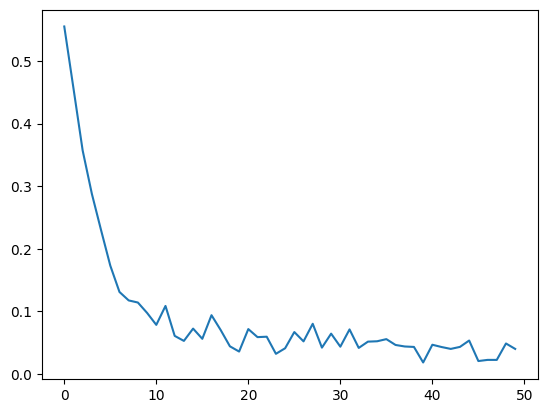

In [ ]:
# 학습 과정에서 저장된 손실 값(Loss)을 그래프로 출력
plt.plot(Loss)

In [ ]:
# X_test_ts.to(device)는 테스트 데이터를 현재 설정된 디바이스로 이동
# 예측을 수행하고, 결과를 CPU로 다시 이동시킨 후 numpy 배열로 변환
#  > 0.5 조건을 사용하여 모델의 출력(확률)을 이진 분류 결정(0 또는 1)으로 변환
y_pred = (model(X_test_ts.to(device)).numpy(force=True) > 0.5)
y_pred

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
# y_test와 y_pred를 비교하여 정확도(accuracy) 계산
sum(y_test == y_pred.flatten()) / len(y_test)

0.986

### - Malware Dataset 실습을 바탕으로 다른 이진 분류 문제에도 동일한 MLP 구조를 적용해보세요.

In [7]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X.shape, y.shape

((569, 30), (569,))